In [42]:
import pandas as pd
import os
from utils.ml_utils import RFEmissionsPredictionPipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
SCRIPT_DIR_PATH = os.getcwd()
ROOT_DIR_PATH = os.path.dirname(SCRIPT_DIR_PATH)
DATA_DIR_PATH = os.path.join(ROOT_DIR_PATH, "data")
MAPPING_DIR_PATH = os.path.join(DATA_DIR_PATH, "mapping")
PREDICTORS_DIR_PATH = os.path.join(DATA_DIR_PATH, "predictors")
SSP_DIR_PATH = os.path.join(DATA_DIR_PATH, "ssp")
SIMULATION_DIR_PATH = os.path.join(SSP_DIR_PATH, "sisepuede_run_2025-01-14T17;04;06.975301_output_database")
TRAINING_DIR_PATH = os.path.join(DATA_DIR_PATH, "training")

In [45]:
TRAINING_DATA_PATH = os.path.join(TRAINING_DIR_PATH, "training_data.csv")
training_df = pd.read_csv(TRAINING_DATA_PATH)
training_df = training_df.drop(columns=["primary_id", "future_id"])
training_df.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,total_emissions_last_five_years
0,0.952436,0.360397,0.202990,0.995748,0.369859,0.919920,0.478450,0.445798,0.490988,0.510280,...,0.873715,0.289038,0.996557,0.053597,0.175103,0.379422,0.438093,0.149362,0.869757,670.507643
1,0.304955,0.204875,0.540658,0.800192,0.206396,0.777352,0.805727,0.536048,0.779857,0.623335,...,0.967765,0.536533,0.385371,0.246165,0.101025,0.717013,0.368791,0.774941,0.483352,604.450538
2,0.609262,0.366443,0.601808,0.916668,0.386475,0.181162,0.138910,0.768925,0.884425,0.232722,...,0.080983,0.533412,0.601590,0.122444,0.653845,0.216259,0.714853,0.881270,0.581230,475.708631
3,0.815313,0.487444,0.323954,0.634299,0.064625,0.926815,0.633805,0.439346,0.027114,0.532020,...,0.916428,0.264120,0.938985,0.592915,0.564895,0.027725,0.138890,0.820709,0.250616,758.004335
4,0.973878,0.842718,0.884382,0.483039,0.455502,0.003343,0.571994,0.108021,0.346714,0.892123,...,0.819569,0.430582,0.492564,0.432240,0.662820,0.179231,0.631375,0.395960,0.661637,600.771431


In [46]:
#add sufix group_  to columns except total_emissions_last_five_years to
training_df.columns = ["group_" + col if col != "total_emissions_last_five_years" else col for col in training_df.columns] 
training_df.head()

,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,...,group_39,group_40,group_41,group_42,group_43,group_44,group_45,group_46,group_47,total_emissions_last_five_years
0,0.952436,0.360397,0.202990,0.995748,0.369859,0.919920,0.478450,0.445798,0.490988,0.510280,...,0.873715,0.289038,0.996557,0.053597,0.175103,0.379422,0.438093,0.149362,0.869757,670.507643
1,0.304955,0.204875,0.540658,0.800192,0.206396,0.777352,0.805727,0.536048,0.779857,0.623335,...,0.967765,0.536533,0.385371,0.246165,0.101025,0.717013,0.368791,0.774941,0.483352,604.450538
2,0.609262,0.366443,0.601808,0.916668,0.386475,0.181162,0.138910,0.768925,0.884425,0.232722,...,0.080983,0.533412,0.601590,0.122444,0.653845,0.216259,0.714853,0.881270,0.581230,475.708631
3,0.815313,0.487444,0.323954,0.634299,0.064625,0.926815,0.633805,0.439346,0.027114,0.532020,...,0.916428,0.264120,0.938985,0.592915,0.564895,0.027725,0.138890,0.820709,0.250616,758.004335
4,0.973878,0.842718,0.884382,0.483039,0.455502,0.003343,0.571994,0.108021,0.346714,0.892123,...,0.819569,0.430582,0.492564,0.432240,0.662820,0.179231,0.631375,0.395960,0.661637,600.771431


In [47]:
# Set some parameters
use_pca = False

## EDA

In [48]:
training_df["total_emissions_last_five_years"].describe()

count    1.000000e+03
mean     7.690960e+05
std      1.071674e+07
min      3.616263e+02
25%      6.362033e+02
50%      7.210529e+02
75%      7.955229e+02
max      2.268719e+08
Name: total_emissions_last_five_years, dtype: float64

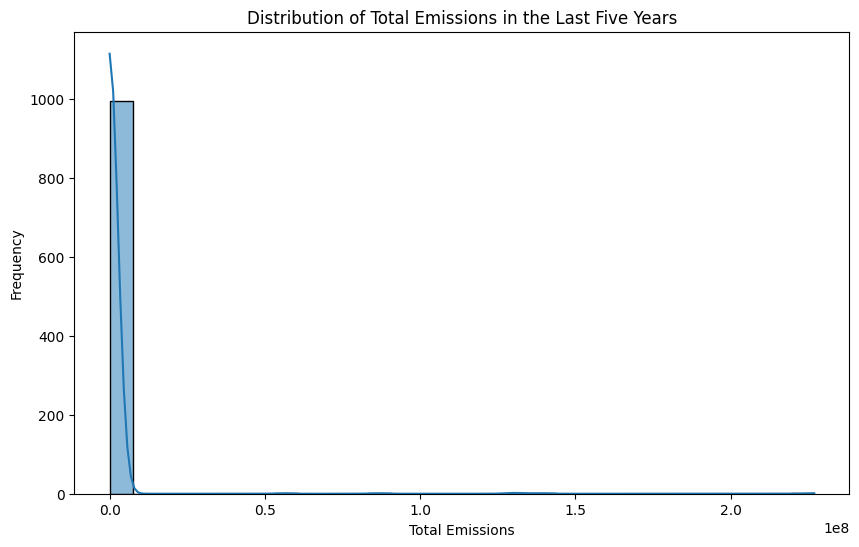

In [49]:
def plot_emissions_histogram(df, column="total_emissions_last_five_years", bins=30, kde=True, title="Distribution of Total Emissions in the Last Five Years"):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=bins, kde=kde)
    plt.title(title)
    plt.xlabel("Total Emissions")
    plt.ylabel("Frequency")
    plt.show()

plot_emissions_histogram(training_df)


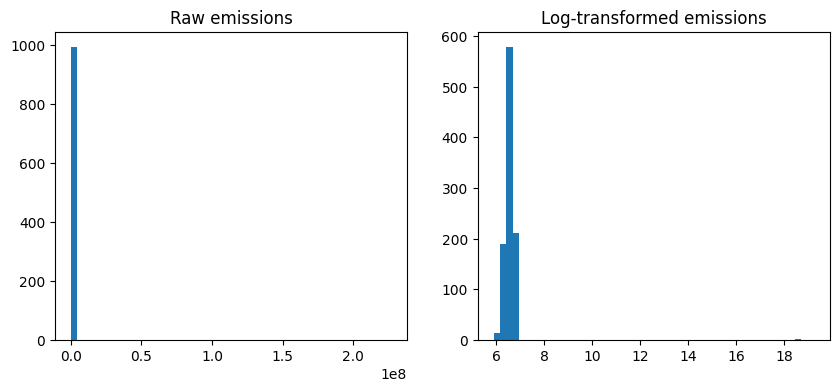

In [50]:
y = training_df['total_emissions_last_five_years']
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(y, bins=50)
ax[0].set_title("Raw emissions")
ax[1].hist(np.log1p(y), bins=50)
ax[1].set_title("Log-transformed emissions")
plt.show()


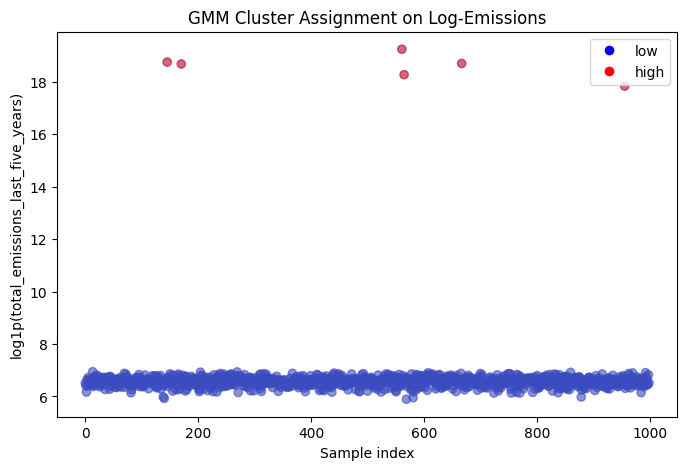

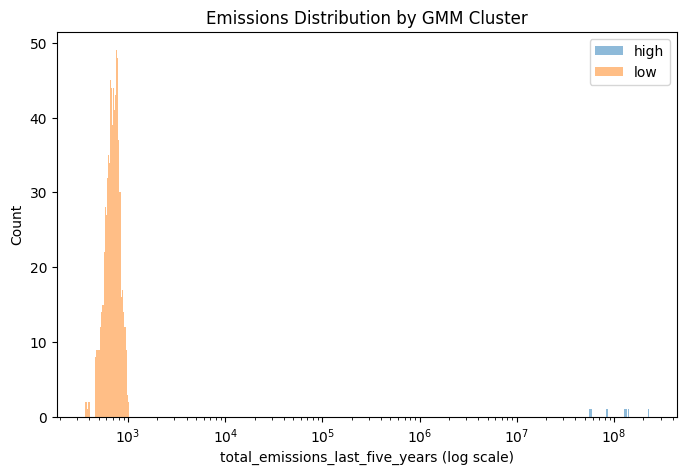

In [51]:
from sklearn.mixture import GaussianMixture

# 1. Fit GMM on log1p(target)
y = training_df['total_emissions_last_five_years']
log_y = np.log1p(y).values.reshape(-1,1)

gm = GaussianMixture(n_components=2, random_state=0)
labels = gm.fit_predict(log_y)

# 2. Map labels to “low” vs “high” based on cluster means
means = gm.means_.flatten()
low_lab, high_lab = np.argsort(means)
label_map = {low_lab: 'low', high_lab: 'high'}

training_df['cluster'] = labels
training_df['cluster_name'] = training_df['cluster'].map(label_map)

# 3. Scatter plot of log-emissions colored by cluster
plt.figure(figsize=(8,5))
plt.scatter(training_df.index, log_y.flatten(),
            c=training_df['cluster'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Sample index')
plt.ylabel('log1p(total_emissions_last_five_years)')
plt.title('GMM Cluster Assignment on Log-Emissions')
plt.legend(handles=[
    plt.Line2D([], [], marker='o', color='w', label='low',  markerfacecolor='blue', markersize=8),
    plt.Line2D([], [], marker='o', color='w', label='high', markerfacecolor='red',  markersize=8)
])
plt.show()

# 4. (Optional) Overlaid histograms on original scale
plt.figure(figsize=(8,5))
for name, grp in training_df.groupby('cluster_name'):
    plt.hist(grp['total_emissions_last_five_years'],
             bins=50, alpha=0.5, label=name)
plt.xscale('log')
plt.xlabel('total_emissions_last_five_years (log scale)')
plt.ylabel('Count')
plt.title('Emissions Distribution by GMM Cluster')
plt.legend()
plt.show()


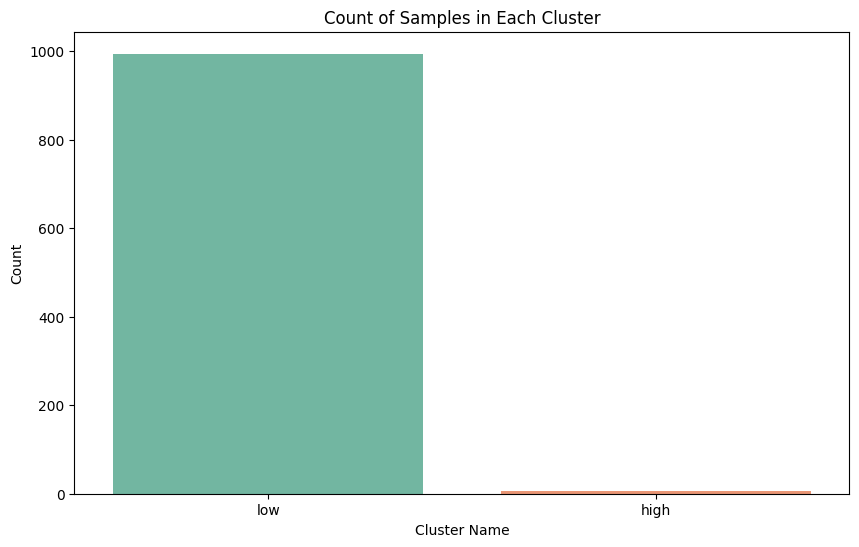

In [52]:
# plot bar graph of the two categories of cluster name
plt.figure(figsize=(10, 6))
sns.countplot(data=training_df, x='cluster_name', palette='Set2', hue="cluster_name")
plt.title("Count of Samples in Each Cluster")
plt.xlabel("Cluster Name")
plt.ylabel("Count")
plt.show()

## Data Cleaning

In [53]:
training_df.head()

,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,...,group_41,group_42,group_43,group_44,group_45,group_46,group_47,total_emissions_last_five_years,cluster,cluster_name
0,0.952436,0.360397,0.202990,0.995748,0.369859,0.919920,0.478450,0.445798,0.490988,0.510280,...,0.996557,0.053597,0.175103,0.379422,0.438093,0.149362,0.869757,670.507643,0,low
1,0.304955,0.204875,0.540658,0.800192,0.206396,0.777352,0.805727,0.536048,0.779857,0.623335,...,0.385371,0.246165,0.101025,0.717013,0.368791,0.774941,0.483352,604.450538,0,low
2,0.609262,0.366443,0.601808,0.916668,0.386475,0.181162,0.138910,0.768925,0.884425,0.232722,...,0.601590,0.122444,0.653845,0.216259,0.714853,0.881270,0.581230,475.708631,0,low
3,0.815313,0.487444,0.323954,0.634299,0.064625,0.926815,0.633805,0.439346,0.027114,0.532020,...,0.938985,0.592915,0.564895,0.027725,0.138890,0.820709,0.250616,758.004335,0,low
4,0.973878,0.842718,0.884382,0.483039,0.455502,0.003343,0.571994,0.108021,0.346714,0.892123,...,0.492564,0.432240,0.662820,0.179231,0.631375,0.395960,0.661637,600.771431,0,low


In [54]:
# remove cluster == 1
training_df = training_df[training_df['cluster'] == 0]
training_df = training_df.drop(columns=['cluster', 'cluster_name'])
training_df.head()

,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,...,group_39,group_40,group_41,group_42,group_43,group_44,group_45,group_46,group_47,total_emissions_last_five_years
0,0.952436,0.360397,0.202990,0.995748,0.369859,0.919920,0.478450,0.445798,0.490988,0.510280,...,0.873715,0.289038,0.996557,0.053597,0.175103,0.379422,0.438093,0.149362,0.869757,670.507643
1,0.304955,0.204875,0.540658,0.800192,0.206396,0.777352,0.805727,0.536048,0.779857,0.623335,...,0.967765,0.536533,0.385371,0.246165,0.101025,0.717013,0.368791,0.774941,0.483352,604.450538
2,0.609262,0.366443,0.601808,0.916668,0.386475,0.181162,0.138910,0.768925,0.884425,0.232722,...,0.080983,0.533412,0.601590,0.122444,0.653845,0.216259,0.714853,0.881270,0.581230,475.708631
3,0.815313,0.487444,0.323954,0.634299,0.064625,0.926815,0.633805,0.439346,0.027114,0.532020,...,0.916428,0.264120,0.938985,0.592915,0.564895,0.027725,0.138890,0.820709,0.250616,758.004335
4,0.973878,0.842718,0.884382,0.483039,0.455502,0.003343,0.571994,0.108021,0.346714,0.892123,...,0.819569,0.430582,0.492564,0.432240,0.662820,0.179231,0.631375,0.395960,0.661637,600.771431


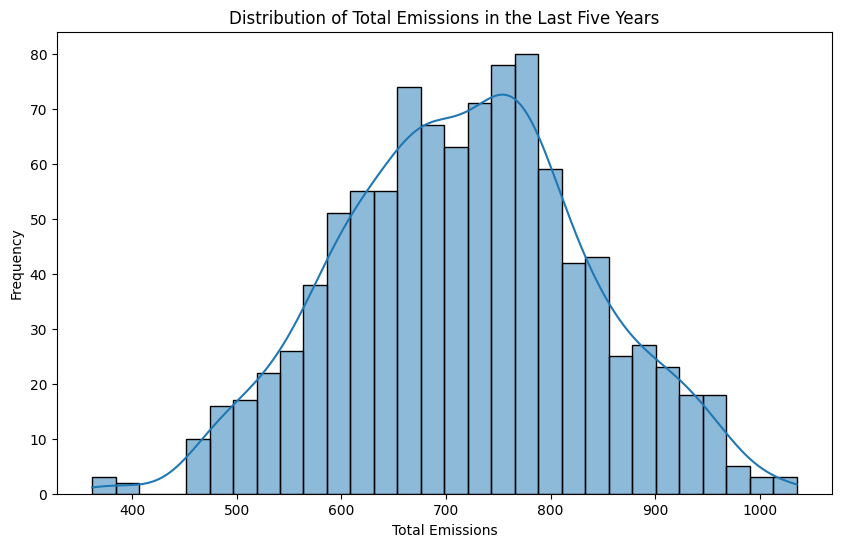

In [55]:
plot_emissions_histogram(training_df)

In [56]:
training_df["total_emissions_last_five_years"].describe()

count     994.000000
mean      717.252770
std       117.737676
min       361.626320
25%       635.400195
50%       719.714422
75%       794.299010
max      1035.283867
Name: total_emissions_last_five_years, dtype: float64

## EDA Again

In [57]:
# Correlation with target
corr = training_df.corr()["total_emissions_last_five_years"].sort_values(ascending=True)
print("Top 10 Correlated Features:\n", corr.head(11))


Top 10 Correlated Features:
 group_34   -0.563134
group_31   -0.541870
group_17   -0.329696
group_15   -0.205931
group_26   -0.177006
group_30   -0.099941
group_28   -0.092488
group_19   -0.090081
group_5    -0.080662
group_29   -0.071375
group_46   -0.070993
Name: total_emissions_last_five_years, dtype: float64


In [58]:
from sklearn.feature_selection import VarianceThreshold

def plot_all_histograms(df: pd.DataFrame,
                        bins: int = 30,
                        max_cols: int = 4,
                        figsize_per_plot: tuple = (4,3)):
    """
    Plot histograms for every column in df, arranged in a grid.
    
    Parameters
    ----------
    df : DataFrame of numeric features
    bins : number of bins per histogram
    max_cols : number of subplots per row
    figsize_per_plot : (width, height) of each subplot
    """
    n_features = len(df.columns)
    n_rows = int(np.ceil(n_features / max_cols))
    fig, axes = plt.subplots(n_rows, max_cols,
                             figsize=(figsize_per_plot[0]*max_cols,
                                      figsize_per_plot[1]*n_rows))
    axes = axes.flatten()
    for ax, col in zip(axes, df.columns):
        ax.hist(df[col].dropna(), bins=bins, edgecolor='black')
        ax.set_title(col)
    # turn off any unused axes
    for ax in axes[n_features:]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()


def find_constant_columns(df: pd.DataFrame) -> list:
    """
    Return list of columns with zero variance.
    """
    selector = VarianceThreshold(threshold=0.0)
    selector.fit(df)
    constant_mask = ~selector.get_support()
    return list(df.columns[constant_mask])


def find_near_constant_columns(df: pd.DataFrame,
                               threshold: float = 0.01) -> list:
    """
    Return list of columns whose variance is <= threshold.
    
    Parameters
    ----------
    threshold : float
        Any column with var <= threshold is considered near-constant.
    """
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df)
    near_constant_mask = ~selector.get_support()
    return list(df.columns[near_constant_mask])


def numeric_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a summary table with common univariate stats:
      mean, std, skew, kurtosis, min, 25%, 50%, 75%, max, missing%
    """
    desc = df.describe().T
    desc['skew']     = df.skew()
    desc['kurtosis'] = df.kurtosis()
    desc['missing_pct'] = df.isna().mean() * 100
    return desc[['mean','std','skew','kurtosis',
                 'min','25%','50%','75%','max','missing_pct']]


def find_outlier_columns(df: pd.DataFrame,
                         z_thresh: float = 3.0) -> dict:
    """
    Identify columns with extreme outliers via z-score.
    Returns a dict mapping column -> % of rows with |z| > z_thresh.
    """
    from scipy.stats import zscore
    zs = df.apply(zscore).abs()
    outlier_pct = (zs > z_thresh).sum() / len(df) * 100
    return outlier_pct[outlier_pct>0].to_dict()


In [59]:
num_df = training_df.select_dtypes(include='number')

# 1. Quick summary table
summary = numeric_summary(num_df)
summary

,mean,std,skew,kurtosis,min,25%,50%,75%,max,missing_pct
group_1,0.500003,0.288842,0.003012,-1.198627,0.000850,0.250898,0.499039,0.750318,0.999183,0.0
group_2,0.500113,0.288886,0.002876,-1.200551,0.000067,0.250548,0.498634,0.750657,0.999497,0.0
group_3,0.499716,0.288986,-0.000231,-1.202523,0.000571,0.249736,0.499759,0.750569,0.999764,0.0
group_4,0.499611,0.289009,0.003338,-1.197815,0.000150,0.249617,0.498790,0.748885,0.999340,0.0
group_5,0.500586,0.288823,-0.001312,-1.199085,0.000513,0.251015,0.501031,0.750517,0.999854,0.0
group_6,0.499922,0.288631,0.000726,-1.195124,0.000227,0.251004,0.499962,0.748178,0.999678,0.0
group_7,0.498107,0.288441,0.007282,-1.197463,0.000652,0.248895,0.497038,0.747499,0.999929,0.0
group_8,0.500282,0.289327,-0.003058,-1.203956,0.000971,0.249580,0.501932,0.750333,0.999089,0.0
group_9,0.499480,0.288496,0.000440,-1.200406,0.000062,0.250001,0.498576,0.749396,0.998928,0.0
group_10,0.500056,0.288683,-0.000390,-1.197067,0.000576,0.250994,0.500086,0.749200,0.999630,0.0


In [60]:
# 2. Find constant / near-constant cols
const_cols      = find_constant_columns(num_df)
near_const_cols = find_near_constant_columns(num_df, threshold=1e-2)
print("Constant:", const_cols)
print("Near-constant:", near_const_cols)

Constant: []
Near-constant: []


In [61]:
# 3. Outlier inspection
outliers = find_outlier_columns(num_df, z_thresh=3.0)
print("Outlier percentages:", outliers)

Outlier percentages: {'total_emissions_last_five_years': 0.1006036217303823}


In [62]:
# 4. Plot all histograms (will show a big grid of 80 plots)
# plot_all_histograms(num_df, bins=30, max_cols=5, figsize_per_plot=(3,2))

In [63]:
from scipy.stats import zscore

# Remove outliers from total_emissions_last_five_years
outlier_mask = np.abs(zscore(num_df['total_emissions_last_five_years'])) > 3.0
training_df = training_df[~outlier_mask]
# Recompute the summary after removing outliers
num_df = training_df.select_dtypes(include='number')
outliers = find_outlier_columns(num_df, z_thresh=3.0)
print("Outlier percentages:", outliers)

Outlier percentages: {}


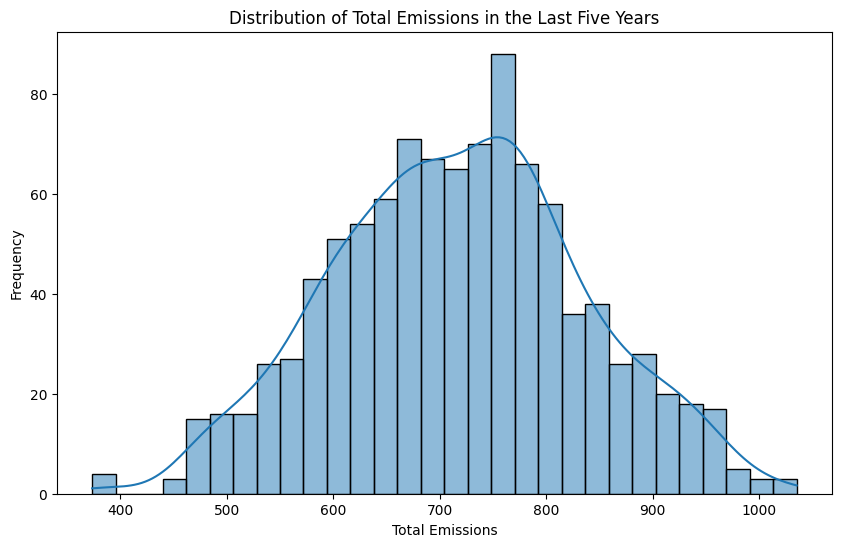

In [64]:
plot_emissions_histogram(training_df)

In [65]:
# from ydata_profiling import ProfileReport


# profile = ProfileReport(training_df, title="Profiling Report")
# profile.to_notebook_iframe()

## Preprocessing

In [66]:
def drop_highly_correlated(df, thresh=0.9, drop=True):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thresh)]
    if drop:
        print(f"Dropping {len(to_drop)} columns with correlation > {thresh}: {to_drop}")
    else:
        print(f"Columns with correlation > {thresh}: {to_drop}")
        return None


    return df.drop(columns=to_drop), to_drop

drop_highly_correlated(training_df, thresh=0.9, drop=False)

Columns with correlation > 0.9: []


In [67]:
from sklearn.decomposition import PCA

def pca_reduce(df, var_threshold=0.95):
    pca = PCA(n_components=var_threshold)
    Xp = pca.fit_transform(df)
    return pd.DataFrame(Xp,
                        columns=[f"PC{i+1}" for i in range(Xp.shape[1])],
                        index=df.index), pca

if use_pca:
    print("Reducing features using PCA...")
    pca_df, pca = pca_reduce(training_df.drop(columns="total_emissions_last_five_years"), var_threshold=0.95)
    print(f"Reduced to {pca_df.shape[1]} components explaining {pca.explained_variance_ratio_.sum():.2f} variance.")
    training_df = pd.concat([pca_df, training_df['total_emissions_last_five_years']], axis=1)

training_df.head()



,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,...,group_39,group_40,group_41,group_42,group_43,group_44,group_45,group_46,group_47,total_emissions_last_five_years
0,0.952436,0.360397,0.202990,0.995748,0.369859,0.919920,0.478450,0.445798,0.490988,0.510280,...,0.873715,0.289038,0.996557,0.053597,0.175103,0.379422,0.438093,0.149362,0.869757,670.507643
1,0.304955,0.204875,0.540658,0.800192,0.206396,0.777352,0.805727,0.536048,0.779857,0.623335,...,0.967765,0.536533,0.385371,0.246165,0.101025,0.717013,0.368791,0.774941,0.483352,604.450538
2,0.609262,0.366443,0.601808,0.916668,0.386475,0.181162,0.138910,0.768925,0.884425,0.232722,...,0.080983,0.533412,0.601590,0.122444,0.653845,0.216259,0.714853,0.881270,0.581230,475.708631
3,0.815313,0.487444,0.323954,0.634299,0.064625,0.926815,0.633805,0.439346,0.027114,0.532020,...,0.916428,0.264120,0.938985,0.592915,0.564895,0.027725,0.138890,0.820709,0.250616,758.004335
4,0.973878,0.842718,0.884382,0.483039,0.455502,0.003343,0.571994,0.108021,0.346714,0.892123,...,0.819569,0.430582,0.492564,0.432240,0.662820,0.179231,0.631375,0.395960,0.661637,600.771431


## ML

In [68]:
#TODO: OPEN THE CLASS HERE
epp = RFEmissionsPredictionPipeline(training_df, target="total_emissions_last_five_years", test_size=0.2, random_state=42,)

In [69]:
epp.df

,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,...,group_39,group_40,group_41,group_42,group_43,group_44,group_45,group_46,group_47,total_emissions_last_five_years
0,0.952436,0.360397,0.202990,0.995748,0.369859,0.919920,0.478450,0.445798,0.490988,0.510280,...,0.873715,0.289038,0.996557,0.053597,0.175103,0.379422,0.438093,0.149362,0.869757,670.507643
1,0.304955,0.204875,0.540658,0.800192,0.206396,0.777352,0.805727,0.536048,0.779857,0.623335,...,0.967765,0.536533,0.385371,0.246165,0.101025,0.717013,0.368791,0.774941,0.483352,604.450538
2,0.609262,0.366443,0.601808,0.916668,0.386475,0.181162,0.138910,0.768925,0.884425,0.232722,...,0.080983,0.533412,0.601590,0.122444,0.653845,0.216259,0.714853,0.881270,0.581230,475.708631
3,0.815313,0.487444,0.323954,0.634299,0.064625,0.926815,0.633805,0.439346,0.027114,0.532020,...,0.916428,0.264120,0.938985,0.592915,0.564895,0.027725,0.138890,0.820709,0.250616,758.004335
4,0.973878,0.842718,0.884382,0.483039,0.455502,0.003343,0.571994,0.108021,0.346714,0.892123,...,0.819569,0.430582,0.492564,0.432240,0.662820,0.179231,0.631375,0.395960,0.661637,600.771431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.218189,0.886941,0.569155,0.107766,0.955775,0.380014,0.569711,0.312233,0.791412,0.300450,...,0.403915,0.004788,0.319760,0.567859,0.873065,0.309462,0.213959,0.531121,0.413153,623.338641
996,0.510025,0.235856,0.847465,0.138888,0.182086,0.453749,0.242018,0.215693,0.657012,0.808412,...,0.968643,0.695228,0.368169,0.356410,0.584330,0.195851,0.217361,0.920388,0.402516,747.358673
997,0.276479,0.612911,0.642697,0.952037,0.176638,0.411246,0.169671,0.694365,0.606286,0.678398,...,0.750968,0.326525,0.828078,0.653782,0.429175,0.977175,0.914779,0.307569,0.506892,634.154137
998,0.600573,0.553323,0.306380,0.464389,0.834916,0.786519,0.717580,0.168263,0.009808,0.855097,...,0.790999,0.398381,0.757483,0.826523,0.961181,0.882943,0.900195,0.448056,0.664405,915.717778


In [70]:
# epp.df.info()

MAE: 41.228055635291014
RMSE: 52.25380632204197
R^2 Score: 0.7628583501868247


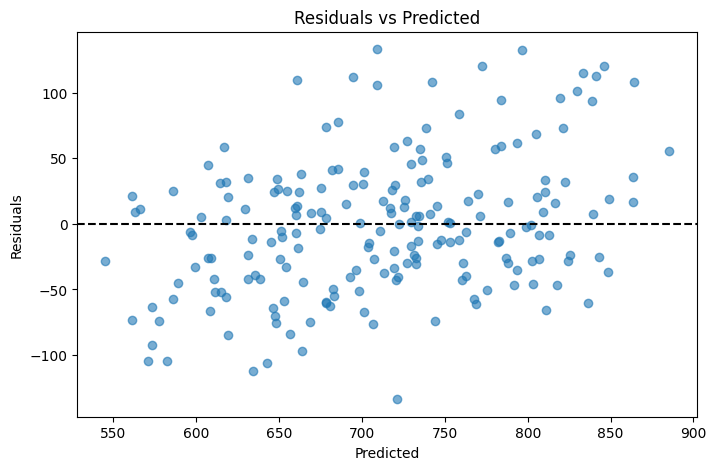

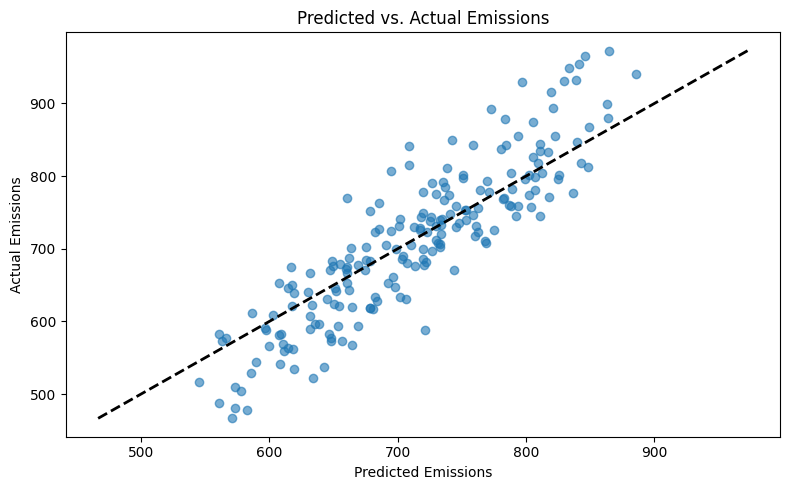

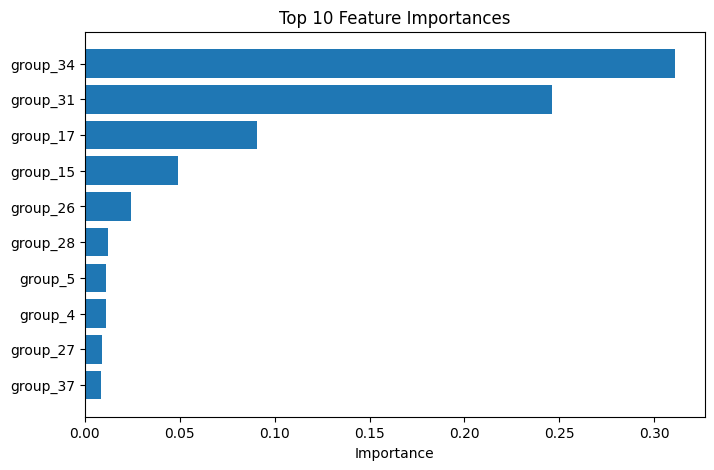

In [73]:
epp.run(tune=False, log_transform=False, feature_select=False)

In [72]:
epp.X_train["18"].head()

KeyError: '18'

In [ ]:
training_df["18"].head()

0    0.281768
1    0.105017
2    0.455781
3    0.012383
4    0.630539
Name: 18, dtype: float64

In [ ]:
epp.X_train.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
       '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '40', '41', '42', '43', '44', '45', '46', '47'],
      dtype='object')